In [15]:
#CS 513: Knowledge Discovery and Data 
#Group Members: Danica Lacuesta, Joelle An, and Raj Rana 
#Author: Danica Lacuesta
#20014543
#"I pledge my honor that I have abided by the Stevens Honor System"
#Purpose: This project analyzes digital activity patterns to classify user stress levels and identify the behavioral features that most strongly impact predictive accuracy.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/df_modified.csv")

# Create binary target
df["Stress_Binary"] = (df["Stress_Level(1-10)"] >= 6).astype(int)
df = df.drop("Stress_Level(1-10)", axis=1)

# Outlier clipping function
def clip_outliers_and_report(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    original_values = df[column].copy()
    df[column] = df[column].clip(lower_bound, upper_bound)

    clipped_values = df[column]
    num_clipped = (original_values != clipped_values).sum()

    print(f"Column: {column}")
    print(f" → Outliers clipped: {num_clipped}")

    if num_clipped > 0:
        changed = pd.DataFrame({
            "Before": original_values[original_values != clipped_values],
            "After": clipped_values[original_values != clipped_values]
        })
        print("\nClipped Values:")
        print(changed)
        print("\n" + "-"*50 + "\n")
    else:
        print(" → No outliers found.\n" + "-"*50 + "\n")

numeric_cols_to_clip = [
    "Daily_Screen_Time(hrs)",
    "Sleep_Quality(1-10)",
    "Happiness_Index(1-10)",
    "Days_Without_Social_Media",
    "Exercise_Frequency(week)",
    "Age"
]

for col in numeric_cols_to_clip:
    clip_outliers_and_report(df, col)

# Create X and y after clipping
X = df.drop("Stress_Binary", axis=1)
y = df["Stress_Binary"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


Column: Daily_Screen_Time(hrs)
 → Outliers clipped: 2

Clipped Values:
     Before  After
248    10.8   10.3
325    10.8   10.3

--------------------------------------------------

Column: Sleep_Quality(1-10)
 → Outliers clipped: 0
 → No outliers found.
--------------------------------------------------

Column: Happiness_Index(1-10)
 → Outliers clipped: 0
 → No outliers found.
--------------------------------------------------

Column: Days_Without_Social_Media
 → Outliers clipped: 0
 → No outliers found.
--------------------------------------------------

Column: Exercise_Frequency(week)
 → Outliers clipped: 2

Clipped Values:
     Before  After
39      7.0    6.0
489     7.0    6.0

--------------------------------------------------

Column: Age
 → Outliers clipped: 0
 → No outliers found.
--------------------------------------------------



Accuracy: 0.8533333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.78      0.72        36
           1       0.93      0.88      0.90       114

    accuracy                           0.85       150
   macro avg       0.80      0.83      0.81       150
weighted avg       0.86      0.85      0.86       150



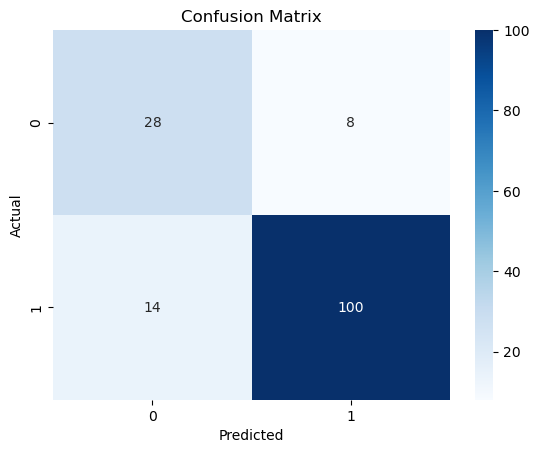

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

nb = GaussianNB()
nb.fit(X_train, y_train)

pred = nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


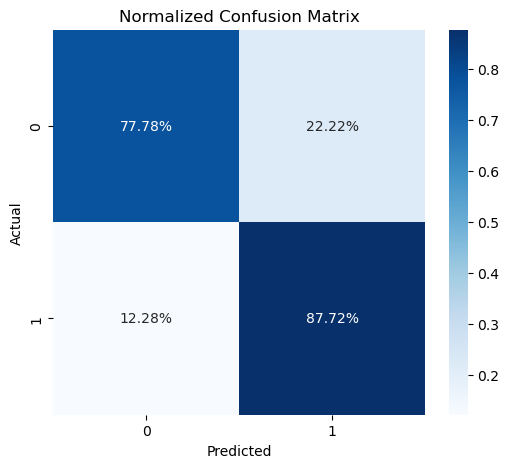

In [18]:
import numpy as np

cm = confusion_matrix(y_test, pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

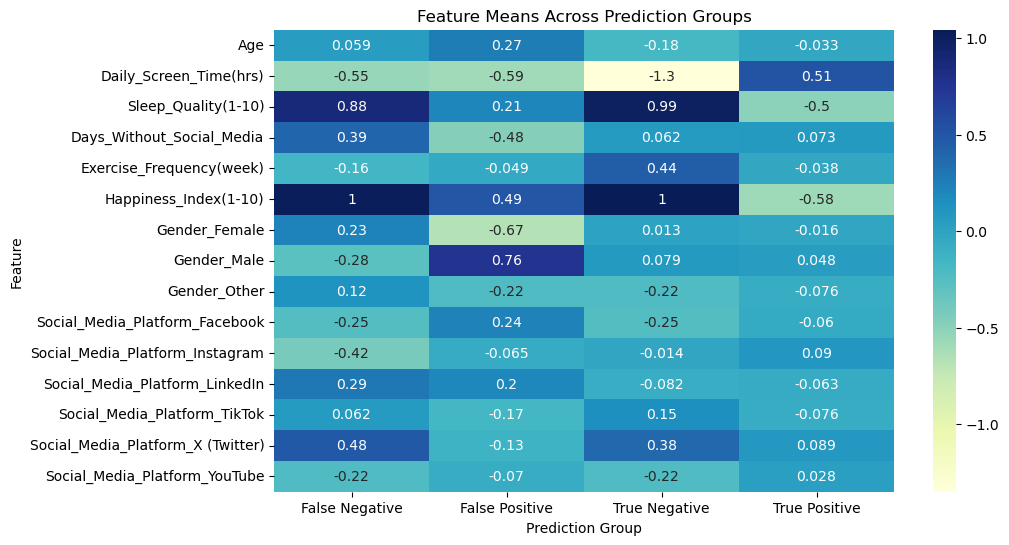

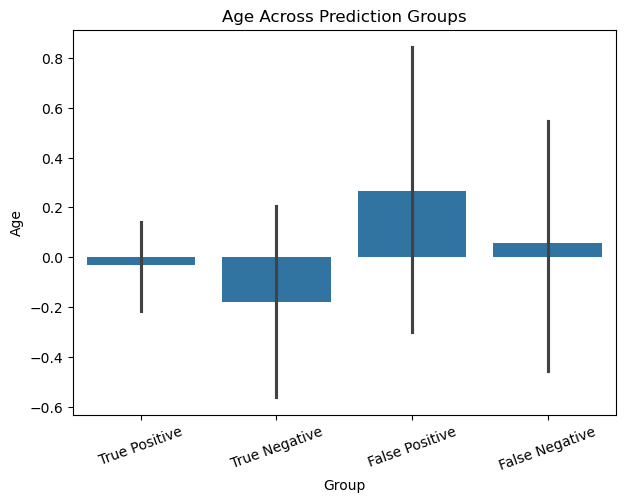

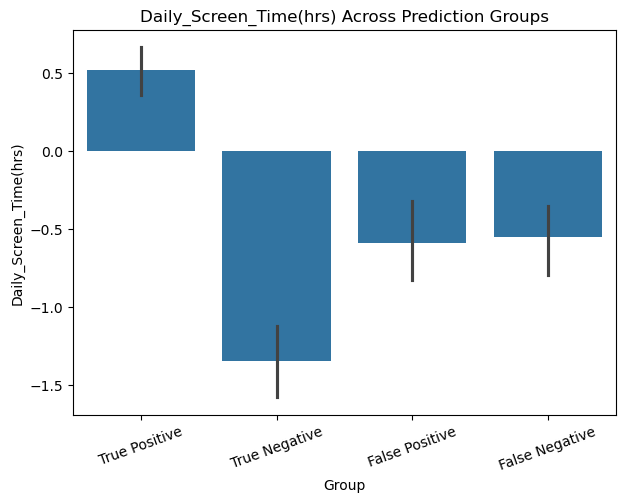

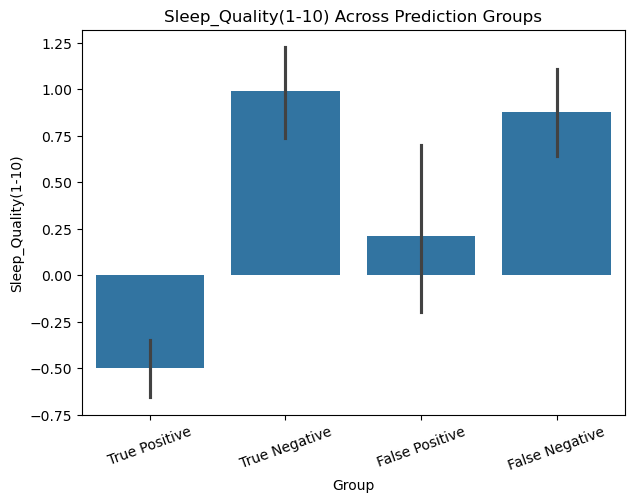

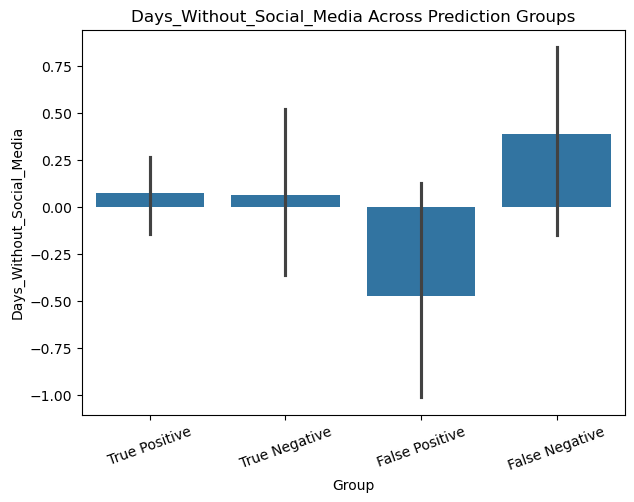

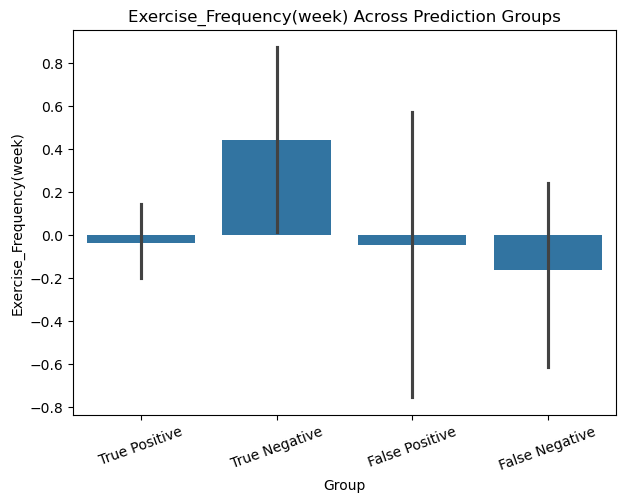

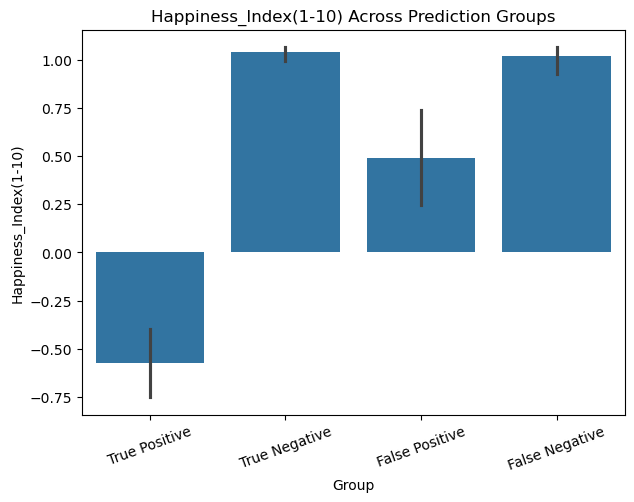

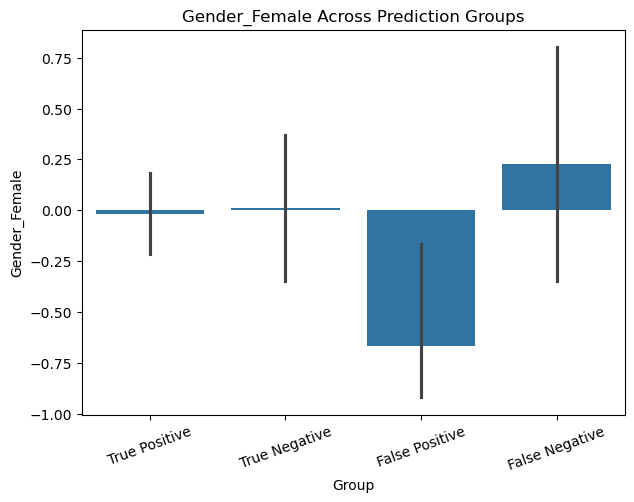

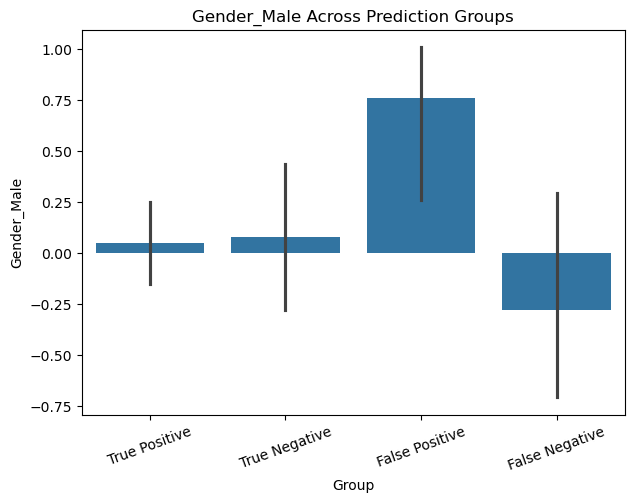

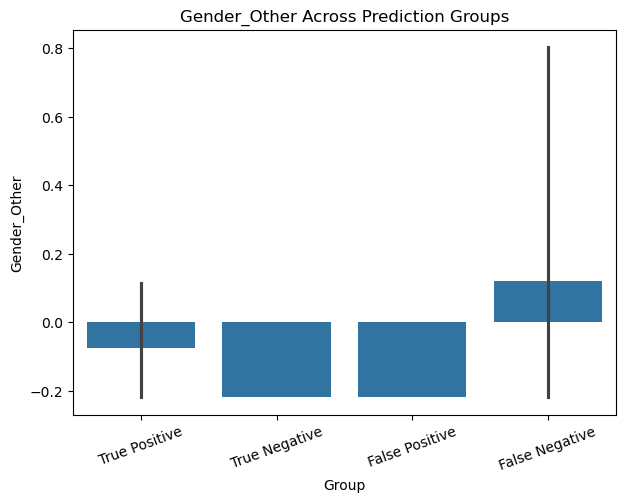

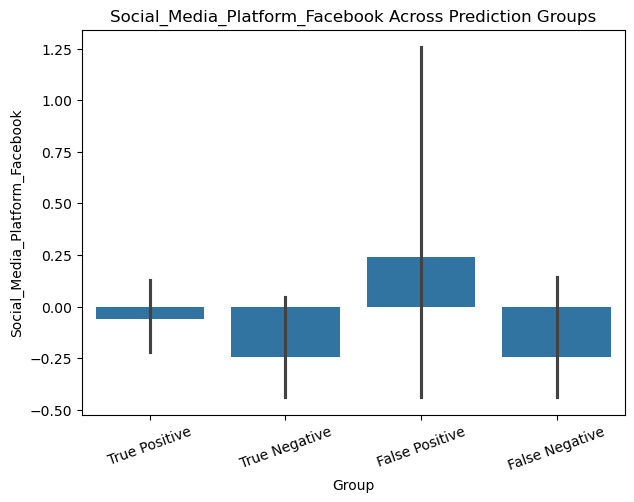

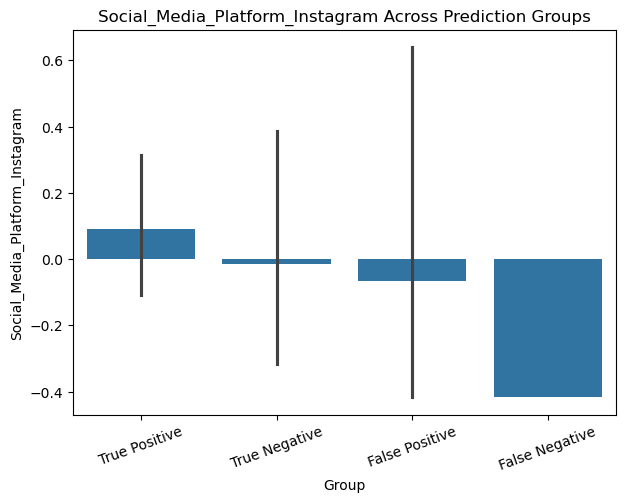

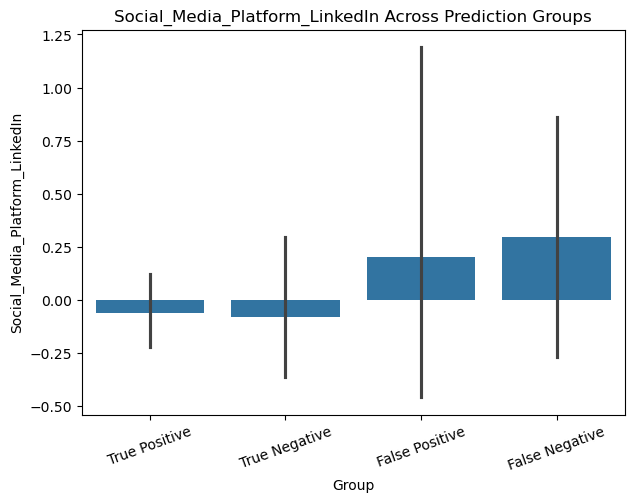

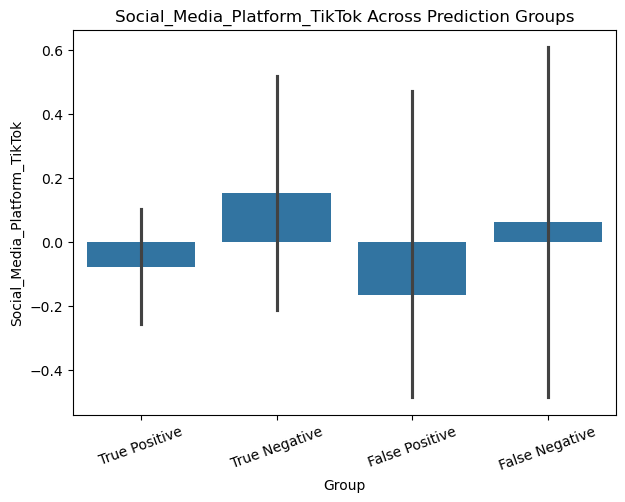

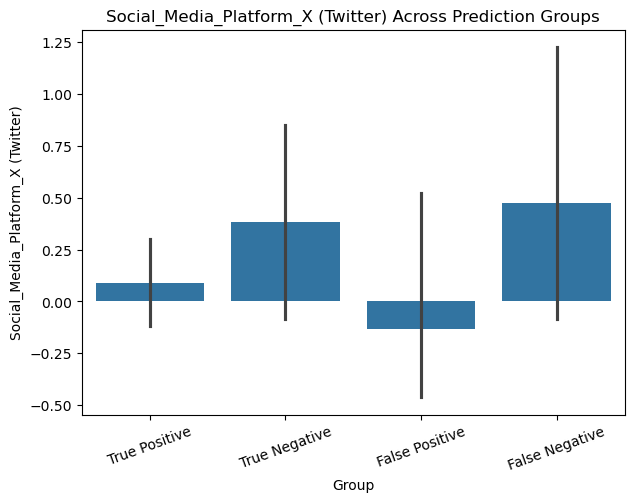

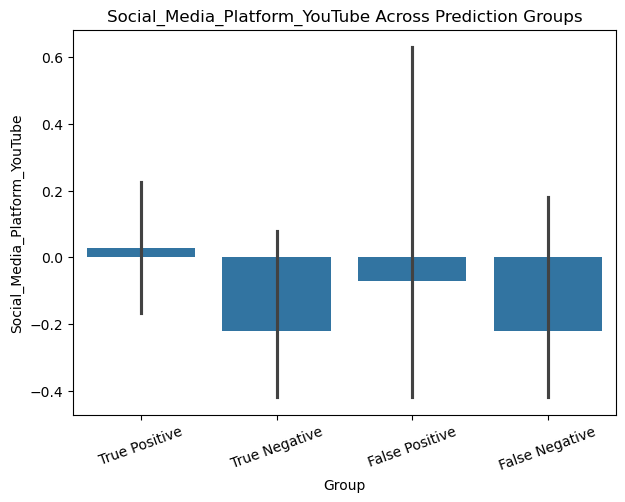

In [19]:
# Convert X_test (scaled NumPy array) back to DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=X.columns).reset_index(drop=True)

results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": pred
})
results = pd.concat([results, X_test_df], axis=1)

def get_group(row):
    if row["Actual"] == 1 and row["Predicted"] == 1:
        return "True Positive"
    if row["Actual"] == 0 and row["Predicted"] == 0:
        return "True Negative"
    if row["Actual"] == 1 and row["Predicted"] == 0:
        return "False Negative"
    if row["Actual"] == 0 and row["Predicted"] == 1:
        return "False Positive"

results["Group"] = results.apply(get_group, axis=1)

features = [
    "Age",
    "Daily_Screen_Time(hrs)",
    "Sleep_Quality(1-10)",
    "Days_Without_Social_Media",
    "Exercise_Frequency(week)",
    "Happiness_Index(1-10)",
    "Gender_Female",
    "Gender_Male",
    "Gender_Other",
    "Social_Media_Platform_Facebook",
    "Social_Media_Platform_Instagram",
    "Social_Media_Platform_LinkedIn",
    "Social_Media_Platform_TikTok",
    "Social_Media_Platform_X (Twitter)",
    "Social_Media_Platform_YouTube"
]



feature_means = results.groupby("Group")[features].mean().T

plt.figure(figsize=(10, 6))
sns.heatmap(feature_means, annot=True, cmap="YlGnBu")
plt.title("Feature Means Across Prediction Groups")
plt.xlabel("Prediction Group")
plt.ylabel("Feature")
plt.show()

order = ["True Positive", "True Negative", "False Positive", "False Negative"]

for feature in features:
    plt.figure(figsize=(7, 5))
    sns.barplot(
        x="Group",
        y=feature,
        data=results,
        order=order
    )

    plt.title(f"{feature} Across Prediction Groups")
    plt.xticks(rotation=20)
    plt.show()


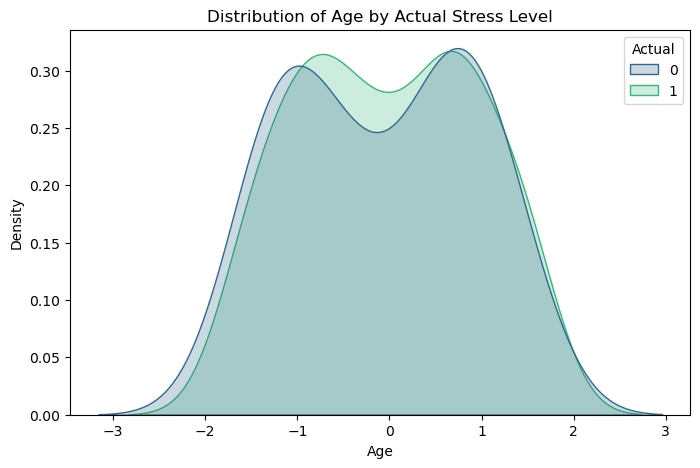

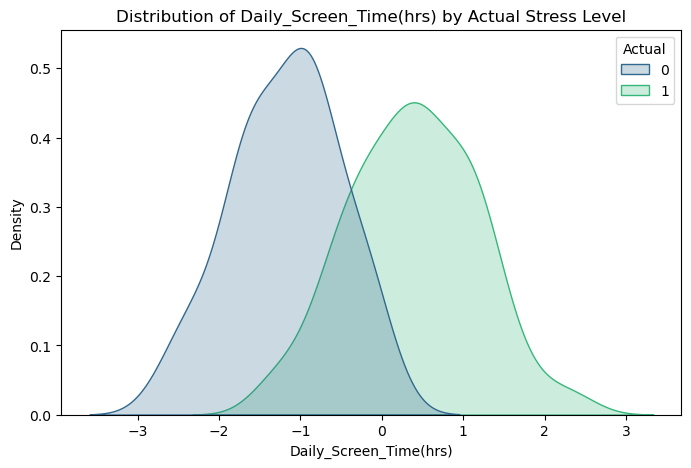

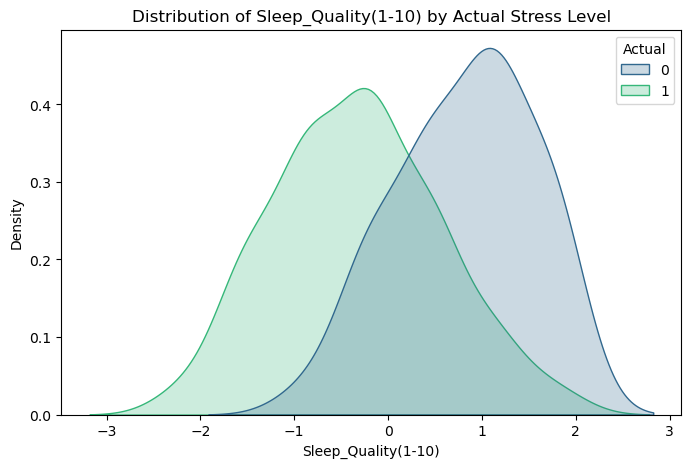

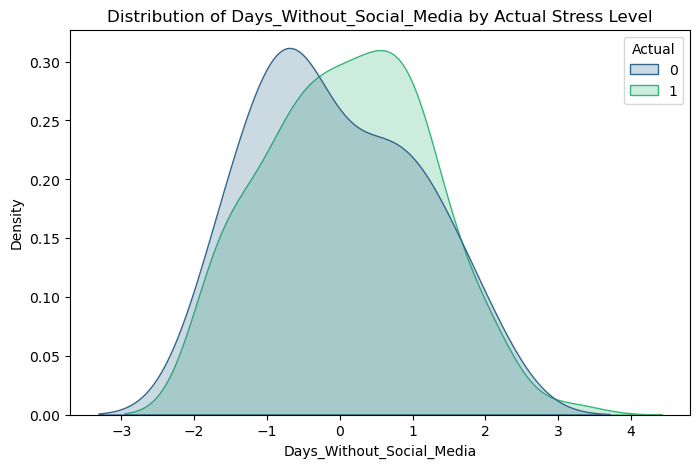

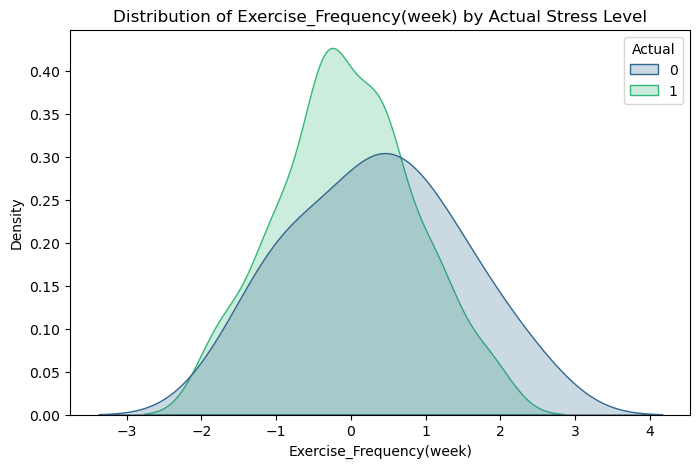

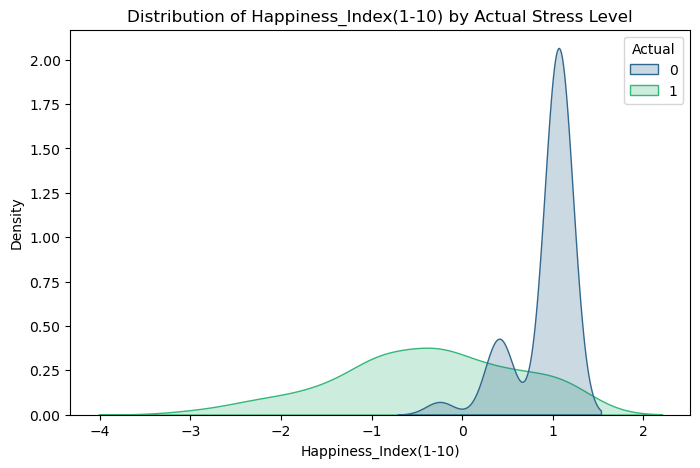

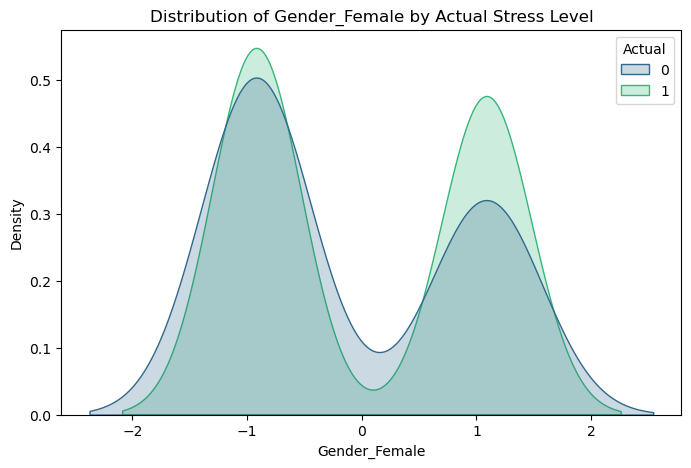

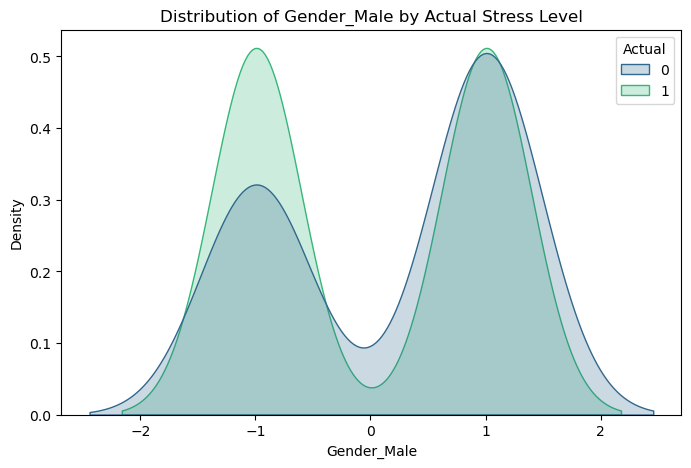

C:\Users\lacue\AppData\Local\Temp\ipykernel_19584\3778854418.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


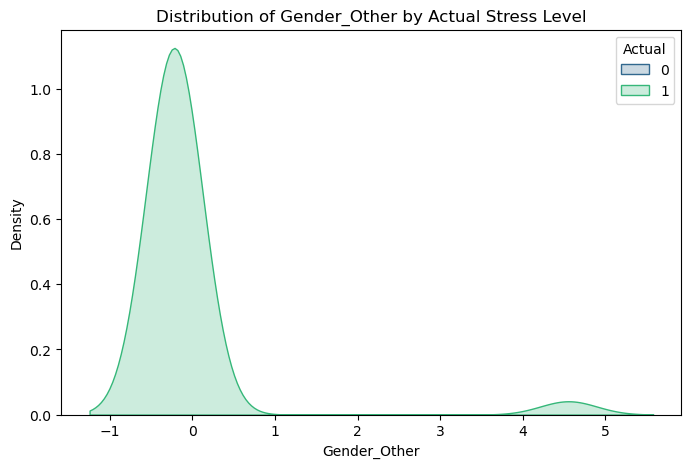

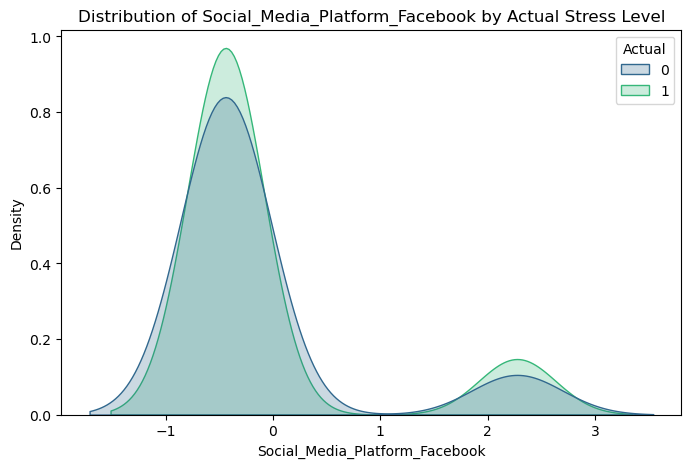

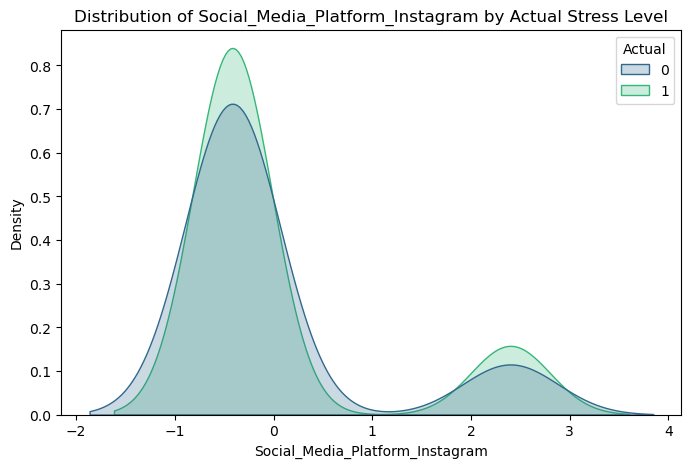

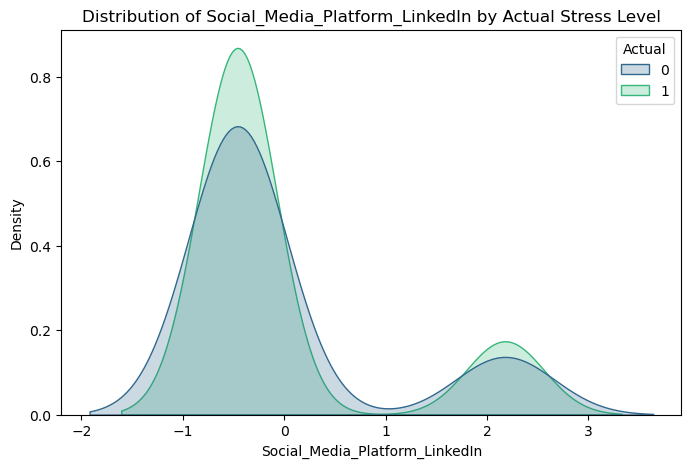

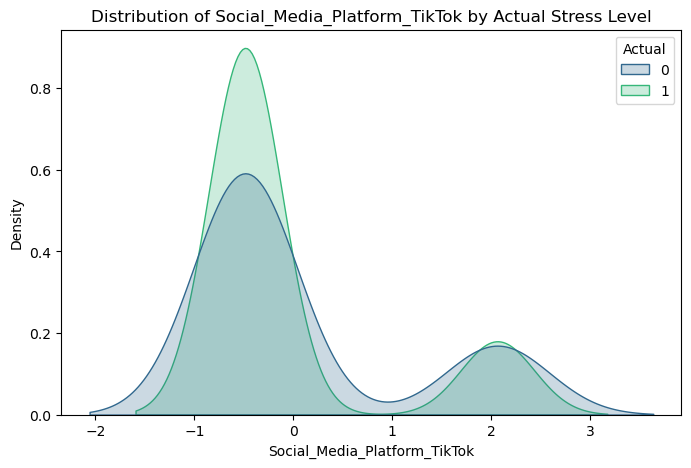

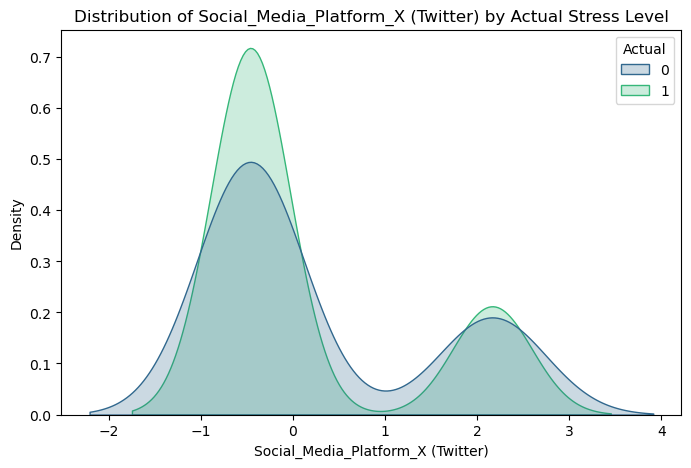

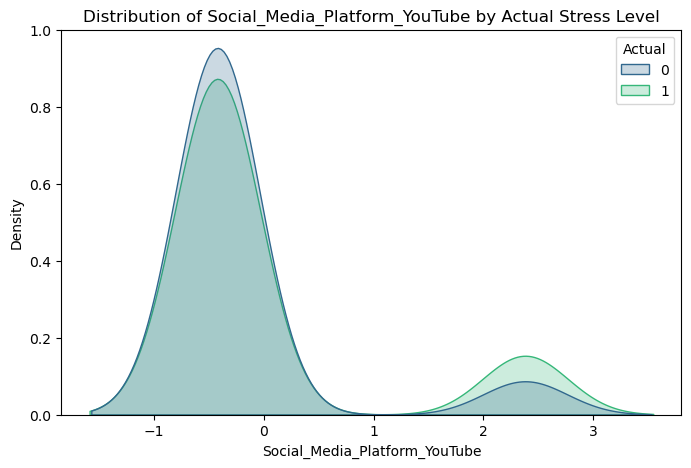

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in features:
    plt.figure(figsize=(8,5))
    sns.kdeplot(
        data=results, 
        x=feature, 
        hue="Actual", 
        fill=True,
        common_norm=False,
        palette="viridis"
    )
    plt.title(f"Distribution of {feature} by Actual Stress Level")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.show()

In [21]:
misclassified_summary = results[results["Group"].isin(["False Positive", "False Negative"])]

print("Counts:")
print(misclassified_summary["Group"].value_counts())

print("\nSamples:")
display(misclassified_summary[["Group"] + features].head(10))


Counts:
Group
False Negative    14
False Positive     8
Name: count, dtype: int64

Samples:


,Group,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10),Gender_Female,Gender_Male,Gender_Other,Social_Media_Platform_Facebook,Social_Media_Platform_Instagram,Social_Media_Platform_LinkedIn,Social_Media_Platform_TikTok,Social_Media_Platform_X (Twitter),Social_Media_Platform_YouTube
7,False Negative,0.403189,-0.479350,1.764096,-0.072164,-1.020332,1.066525,1.087845,-0.992032,-0.219586,-0.439679,-0.416784,-0.45897,-0.484322,-0.46216,2.380476
11,False Positive,0.101702,-0.016210,-0.198919,0.466371,0.392870,1.066525,1.087845,-0.992032,-0.219586,2.274388,-0.416784,-0.45897,-0.484322,-0.46216,-0.420084
14,False Negative,0.302693,-0.305673,1.109758,0.466371,1.099471,1.066525,1.087845,-0.992032,-0.219586,-0.439679,-0.416784,2.17879,-0.484322,-0.46216,-0.420084
18,False Negative,-1.104247,-0.189888,1.764096,1.004906,-1.020332,1.066525,-0.919249,1.008032,-0.219586,-0.439679,-0.416784,-0.45897,2.064742,-0.46216,-0.420084
20,False Negative,-0.300281,-0.247780,0.455419,1.004906,0.392870,1.066525,-0.919249,-0.992032,4.554024,-0.439679,-0.416784,2.17879,-0.484322,-0.46216,-0.420084
25,False Positive,-0.400777,-0.884598,-0.198919,-1.149233,1.099471,0.409798,-0.919249,1.008032,-0.219586,-0.439679,-0.416784,-0.45897,-0.484322,-0.46216,2.380476
30,False Negative,1.508642,-0.305673,1.109758,1.004906,-1.726933,1.066525,1.087845,-0.992032,-0.219586,-0.439679,-0.416784,2.17879,-0.484322,-0.46216,-0.420084
35,False Negative,-1.506230,-0.710921,0.455419,-0.072164,0.392870,1.066525,-0.919249,1.008032,-0.219586,-0.439679,-0.416784,-0.45897,2.064742,-0.46216,-0.420084
39,False Positive,-0.199786,-0.595135,1.109758,-1.687767,1.099471,1.066525,-0.919249,1.008032,-0.219586,-0.439679,2.399324,-0.45897,-0.484322,-0.46216,-0.420084
43,False Positive,1.006163,-1.116168,1.109758,-0.072164,-1.020332,0.409798,-0.919249,1.008032,-0.219586,2.274388,-0.416784,-0.45897,-0.484322,-0.46216,-0.420084
